In [14]:
import pandas as pd

In [15]:
df = pd.read_json("../data/reddit-linux4noobs.jsonl",lines=True)
print(df.shape)
df2 = pd.read_json("../data/reddit-archlinux.jsonl",lines=True)
# df3 = pd.read_json("../data/archwiki_en_dataset.jsonl", lines=True)
print(df2.shape)
df = pd.concat((df, df2))
# df = pd.concat((df, df3))
df = df.drop_duplicates()
df.info()

(605, 5)
(331, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              604 non-null    object
 1   input_text      935 non-null    object
 2   target_text     935 non-null    object
 3   post_upvotes    935 non-null    int64 
 4   post_timestamp  935 non-null    object
dtypes: int64(1), object(4)
memory usage: 43.8+ KB


In [16]:
df = df.drop(columns=["id", "post_upvotes", "post_timestamp"])

In [17]:
df["input_text"] = df["input_text"].str.replace("[deleted]", "", regex=False)
df["target_text"] = df["target_text"].str.replace("[deleted]", "", regex=False)
df["input_text"] = df["input_text"].str.replace("[removed]", "", regex=False)
df["target_text"] = df["target_text"].str.replace("[removed]", "", regex=False)

print(df.shape)
df = df[(df["input_text"].str.strip() != "") & (df["target_text"].str.strip() != "")]
print(df.shape)

(935, 2)
(934, 2)


In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

input_token_counts = df["input_text"].apply(lambda x: len(tokenizer.tokenize(str(x))))
target_token_counts = df["target_text"].apply(lambda x: len(tokenizer.tokenize(str(x))))

print(input_token_counts.describe())
print(target_token_counts.describe())

Token indices sequence length is longer than the specified maximum sequence length for this model (4737 > 512). Running this sequence through the model will result in indexing errors


count     934.000000
mean      331.639186
std       682.968716
min        13.000000
25%        97.000000
50%       166.500000
75%       301.500000
max      9470.000000
Name: input_text, dtype: float64
count     934.000000
mean      571.293362
std       545.387976
min         5.000000
25%       200.500000
50%       435.000000
75%       758.000000
max      5599.000000
Name: target_text, dtype: float64


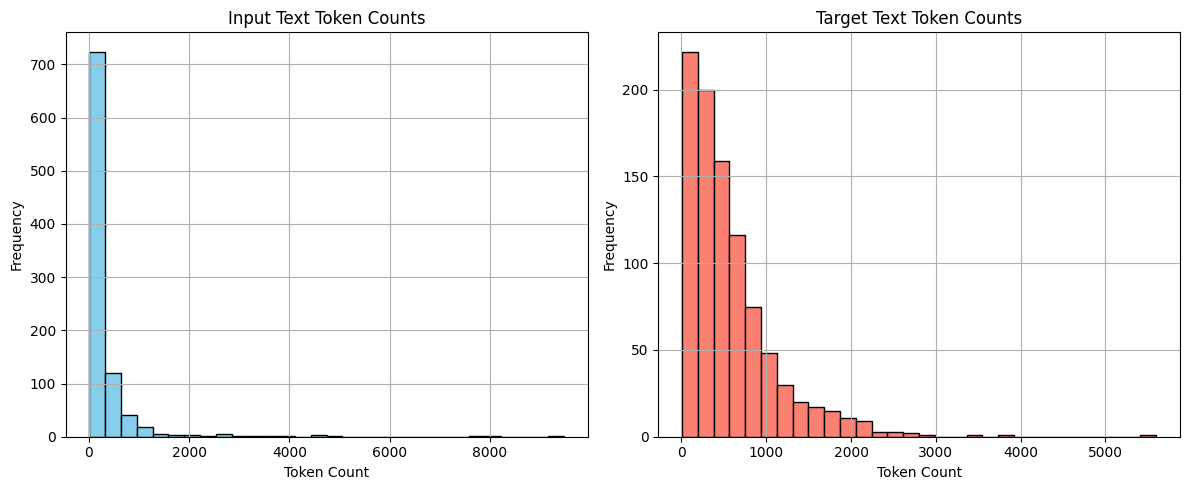

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
input_token_counts.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Input Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
target_token_counts.hist(bins=30, color='salmon', edgecolor='black')
plt.title('Target Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
print(f"\nNumber of rows where input_text has more than 1024 tokens: {(input_token_counts > 1024).sum()}/{df.shape[0]}")
print(f"Number of rows where target_text has more than 1024 tokens: {(target_token_counts > 1024).sum()}/{df.shape[0]}")

# print(f"Number of rows where input_text has fewer than {M} tokens: {(input_token_counts < M).sum()}")
# print(f"Number of rows where target_text has fewer than {M} tokens: {(target_token_counts < M).sum()}")


Number of rows where input_text has more than 1024 tokens: 42/934
Number of rows where target_text has more than 1024 tokens: 145/934


In [21]:
# Filter out rows where input_text or target_text has more than N tokens
print(f"Data shape before trimming: {df.shape}")
df = df[(input_token_counts <= 1024) & (target_token_counts <= 1024)]
print(f"Data shape after trimming: {df.shape}")

Data shape before trimming: (934, 2)
Data shape after trimming: (757, 2)


In [22]:
def split_question_context(text):
    # Try to split at the first occurrence of '\ncontext:' (case-insensitive)
    split_token = '\ncontext:'
    lower_text = text.lower()
    idx = lower_text.find(split_token)
    if idx != -1:
        question = text[:idx].strip()
        context = text[idx:].strip()
        return question, context
    else:
        # If no split token found, treat the whole text as question, context is empty
        return text.strip(), ''

df[["instruction", "input"]] = df["input_text"].apply(
    lambda x: pd.Series(split_question_context(x))
)

df = df.drop(columns=['input_text'])
df = df.rename(columns={'target_text': 'output'})

df = df[["instruction", "input", "output"]]

In [ ]:
df.to_csv("../data/data_2048.csv", index=False)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 0 to 330
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  757 non-null    object
 1   input        757 non-null    object
 2   output       757 non-null    object
dtypes: object(3)
memory usage: 23.7+ KB


In [25]:
df.head()

,instruction,input,output
0,question: Please do NOT try Arch linux just be...,context: Firstly what this is about: Arch lin...,The real requirement for technically demanding...
1,question: Not able to open Porn sites on any b...,context: So I just fresh installed Linux Mint ...,"You gotta install the goon package\n\nAlright,..."
2,question: For the influx of users who came to ...,"context: Heya, have you watched Pewdiepie's vi...","And remember, this is a big chance for Linux t..."
5,question: My brother is proof you can be a com...,context: So I have a younger brother (for the ...,The problem isn't the idiot that knows he's an...
6,question: Why is the Linux filesystem so compl...,context: I have a few questions regarding why ...,/bin - binaries for all to use\n\n/sbin - syst...
